In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import sys, os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
import bandicoot_dev as bc_d
from py_pcha.PCHA import PCHA
from sklearn import decomposition
from build_dataset.analysis.consensus_archetypes import Consensus_archetypes
from build_dataset.analysis.compute_thetas import compute_thetas

In [2]:
# Can only be loaded remotely
from build_dataset.analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd
from build_dataset.extractors.big_five_extractor import Big_five_extractor

In [3]:
tc0 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "31/12/14")
    ],
    'weeks': range(53)
}
tc1 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("06/01/14", "24/01/14"),
        ("03/02/14", "16/05/14"),
        ("01/09/14", "05/12/14"),
        ("02/06/14", "20/06/14")
    ],
    'weeks': range(1, 4) + \
             range(5, 16) + \
             range(17, 20) + \
             range(22, 25) + \
             range(35, 40) + \
             range(41, 49)
}
tc2 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("17/05/14", "01/06/14"),
        ("06/12/14", "21/12/14")
    ],
    'weeks': range(20, 22) + \
             range(49, 52)
}
tc3 = {
    'hours': range(24),
    'days': range(7),
    'spans': [
        ("01/01/14", "05/01/14"),
        ("25/01/14", "02/02/14"),
        ("14/04/14", "20/04/14"),
        ("21/06/14", "30/08/14"),
        ("22/12/14", "31/12/14")
    ],
    'weeks': range(0, 1) + \
             range(4, 5) + \
             range(16, 17) + \
             range(25, 35) + \
             range(40, 41) + \
             range(52, 53)
}

## Compute features

In [ ]:
class SufficiencyException(Exception):
    pass

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        if span == 0:
            return 0
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

def _compute_features(userid, tc="tc0", groupby="week", summary="special"):
    
    user = bc_d.read_csv(
        "%d" % userid, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )

    if not _threshold_test(user):
        raise SufficiencyException("User '%s' has too few records for analysis" % str(userid))
    
    user.start_time['any'] = dt.strptime('01/01/14', "%d/%m/%y")
    user.end_time['any'] = dt.strptime('01/01/15', "%d/%m/%y")
    
    indicators = bc_d.utils.all(
        user,
        groupby=groupby,
        summary=summary,
        dist=True,
        network=False,
        spatial=False
    )

    for ex in ['name', 'reporting']:
        del indicators[ex]

    return bc_d.utils.flatten(indicators), user

def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _number_of_days(groupby):
    if groupby == "week":
        return 7
    if groupby == "month":
        return 30
    if groupby == "year":
        return 365

def _get_periods(tc, groupby):
    """Only works for tc0!"""
    period = _number_of_days(groupby)
    span = tc['spans'][0]
    delta = dt.strptime(span[1], "%d/%m/%y") - \
            dt.strptime(span[0], "%d/%m/%y")
    return int(np.ceil(delta.days/period)) + 1

def _interpolate_nans(X):
    """Overwrite NaNs with column value interpolations."""
    for j in range(X.shape[1]):
        mask_j = np.isnan(X[:,j])
        try:
            X[mask_j,j] = np.interp(np.flatnonzero(mask_j), np.flatnonzero(~mask_j), X[~mask_j,j])
        except ValueError:
            X[mask_j,j] = 0
    return X

def _variance_thresholding(X):
    """Return features with below threshold variance."""
    sel = VarianceThreshold(threshold=(0.5)).fit(X)
    return sel.get_support()
    

def make_dataset(groupby="week", load_cached=True, interpolate_nans=False, variance_thresholding=False, summary="special"):
    if load_cached:
        try:
            X = np.load("data/X_2014_%s.pickle" % groupby)
            Y = np.load("data/Y_2014_%s.pickle" % groupby)
            T = np.load("data/T_2014_%s.pickle" % groupby)
            feat_names = np.load("data/X_2014_%s_feat_names.pickle" % groupby)
            valid_users = np.load("data/XY_2014_%s_valid_users.pickle" % groupby)
        except IOError:
            print "File not found. Building dataset..."
            load_cached = False
            
    if not load_cached:
        big_five = Big_five_extractor()
        users = _processed_users("tc0")
        valid_users = []
        l = 0
        for u in sorted(users):
            print "\n", u
    
            try:
                ds, user = _compute_features(u, groupby=groupby, summary=summary)
            except SufficiencyException as e:
                print e
                continue

            # Initiate
            if l == 0:
                if groupby == None:
                    M = len(ds)
                    N = 1
                else:
                    M = len(ds) + sum([1 for v in ds.values() if type(v[0]) is dict])  # Indicators
                    N = _get_periods(tc0, groupby)
                L = len(users)
                feat_names = []
                X = np.empty((N, M, L))
                Y = np.empty((1, 5, L))

            U = np.full((N, M), None)

            c = 0
            for m, (f, vals) in enumerate(ds.items()):
                if l == 0:
                    if groupby != None and type(vals[0]) is dict:
                        feat_names.append(f + "_mean")
                        feat_names.append(f + "_std")
                    else:
                        feat_names.append(f)
                
                if groupby != None:
                    for n, v in enumerate(vals):
                        # v is either [int, int, int, ...], or [dict, dict, dict, ...]
                        if type(v) is dict:
                            U[n, m + c] = v['mean']
                            U[n, m + c + 1] = v['std']
                            increment_c = True
                        else:
                            U[n, m + c] = v
                            increment_c = False
                else:
                    U[0, m + c] = vals
                    increment_c = False

                if increment_c:
                    c += 1

            try:
                X[:, :, l] = U
                Y[:, :, l] = big_five.main(u)
                valid_users.append(u)
                l+=1
            except:
                print "User", u, "skipped"

        X = X[:, :, :l]  # Not sure if it should be :l or :l+1
        Y = Y[:, :, :l]
        T = compute_thetas(Y.T, penalty='consensus')
        
        X.dump("data/X_2014_%s.pickle" % groupby)
        Y.dump("data/Y_2014_%s.pickle" % groupby)
        T.dump("data/M_2014_%s.pickle" % groupby)
        np.array(feat_names).dump("data/X_2014_%s_feat_names.pickle" % groupby)
        np.array(valid_users).dump("data/XY_2014_%s_valid_users.pickle" % groupby)
        
    if interpolate_nans:
        for l in range(X.shape[2]):
            mask_i = ~np.all(np.isnan(X[:, :, l]) | np.equal(X[:, :, l], 0), axis=1)
            X[mask_i, :, l] = _interpolate_nans(X[mask_i, :, l])
            
    if variance_thresholding:
        support = _variance_thresholding(scale(np.nanmean(X, axis=2)))
        X = X[:, support, :]
        print "Removed %d traits:" % np.sum(~support)
        for r in feat_names[~support]:
            print "  * %d - %s" % (list(feat_names).index(r), r)
        feat_names = feat_names[support]

    return X, Y, T, list(feat_names), list(valid_users)

X, Y, T, feat_names, valid_users = make_dataset(groupby=None, summary="default", load_cached=False, interpolate_nans=True, variance_thresholding=False)

[big_five_extractor] Loaded data from local copy!

0
entropy_per_contacts is slow - time: 0.06
number_of_contacts is slow - time: 0.10
duration is slow - time: 0.15
overlap_conversations_per_contacts is slow - time: 0.41
overlap_screen_physical is slow - time: 0.52

1
User '1' has too few records for analysis

2
percent_nocturnal is slow - time: 0.01
duration is slow - time: 0.01
first_seen_response_rate is slow - time: 0.02
overlap_conversations_per_contacts is slow - time: 0.20
overlap_screen_physical is slow - time: 0.27

3
percent_nocturnal is slow - time: 0.03
duration is slow - time: 0.04
first_seen_response_rate is slow - time: 0.07
overlap_conversations_per_contacts is slow - time: 0.60
overlap_screen_physical is slow - time: 0.99

4

In [6]:
np.mean(M, axis=0)

array([ 0.20925446,  0.02662542,  0.07759642,  0.23629612,  0.27538334,
        0.17484424])

In [20]:
feat_names = ['_'.join(f.split("__allweek__allday__")) for f in feat_names]
list(enumerate(feat_names))

[(0, 'number_of_contacts_stop'),
 (1, 'number_of_contacts_text'),
 (2, 'number_of_contacts_call'),
 (3, 'number_of_contacts_physical'),
 (4, 'number_of_interactions_stop'),
 (5, 'number_of_interactions_text'),
 (6, 'number_of_interactions_call'),
 (7, 'number_of_interactions_physical'),
 (8, 'interactions_per_contact_stop'),
 (9, 'interactions_per_contact_text'),
 (10, 'interactions_per_contact_call'),
 (11, 'interactions_per_contact_physical'),
 (12, 'percent_ei_percent_interactions_text'),
 (13, 'percent_ei_percent_interactions_physical'),
 (14, 'balance_of_interactions_text'),
 (15, 'balance_of_interactions_call'),
 (16, 'entropy_per_contacts_stop'),
 (17, 'entropy_per_contacts_text'),
 (18, 'entropy_per_contacts_call'),
 (19, 'entropy_per_contacts_physical'),
 (20, 'duration_stop'),
 (21, 'duration_text'),
 (22, 'duration_screen'),
 (23, 'duration_call'),
 (24, 'duration_physical'),
 (25, 'percent_ei_percent_durations_stop'),
 (26, 'percent_ei_percent_durations_call'),
 (27, 'perce

### User averages, zscore and save

In [13]:
X_users_mean_tc0 = np.nanmean(X[:, :, :],axis=0).T
X_users_mean_tc0 = scale(X_users_mean_tc0[~np.isnan(X_users_mean_tc0).any(axis=1)])
np.savetxt("data/X_users_mean_tc0.csv", X_users_mean_tc0, delimiter=",")

X_users_mean_tc1 = np.nanmean(X[tc1['weeks'], :, :],axis=0).T
X_users_mean_tc1 = scale(X_users_mean_tc1[~np.isnan(X_users_mean_tc1).any(axis=1)])
np.savetxt("data/X_users_mean_tc1.csv", X_users_mean_tc1, delimiter=",")

X_users_mean_tc2 = np.nanmean(X[tc2['weeks'], :, :],axis=0).T
X_users_mean_tc2 = scale(X_users_mean_tc2[~np.isnan(X_users_mean_tc2).any(axis=1)])
np.savetxt("data/X_users_mean_tc2.csv", X_users_mean_tc2, delimiter=",")

X_users_mean_tc3 = np.nanmean(X[tc3['weeks'], :, :],axis=0).T
X_users_mean_tc3 = scale(X_users_mean_tc3[~np.isnan(X_users_mean_tc3).any(axis=1)])
np.savetxt("data/X_users_mean_tc3.csv", X_users_mean_tc3, delimiter=",")

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


### Detect outliers

In [14]:
out_tc0_svm = Outlier_detector_svm(X_users_mean_tc0, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc0_kd = Outlier_detector_kd(X_users_mean_tc0, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc0_svm = out_tc0_svm.main()
outliers_tc0_kd = out_tc0_kd.main()

X_users_mean_tc0_clean_svm = np.delete(X_users_mean_tc0, outliers_tc0_svm, axis=0)
Y_users_mean_tc0_clean_svm = np.delete(Y[0, :, :].T, outliers_tc0_svm, axis=0)
M_users_mean_tc0_clean_svm = np.delete(M, outliers_tc0_svm, axis=0)
X_users_mean_tc0_clean_kd = np.delete(X_users_mean_tc0, outliers_tc0_kd, axis=0)
Y_users_mean_tc0_clean_kd = np.delete(Y[0, :, :].T, outliers_tc0_kd, axis=0)
M_users_mean_tc0_clean_kd = np.delete(M, outliers_tc0_kd, axis=0)

print "[svm tc0] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc0.shape[0]-X_users_mean_tc0_clean_svm.shape[0]), X_users_mean_tc0_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc0_clean_svm.csv", X_users_mean_tc0_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc0_clean_svm.csv", Y_users_mean_tc0_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc0_clean_svm.csv", M_users_mean_tc0_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc0_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc0_svm)], delimiter=",")
print "[kd tc0] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc0.shape[0]-X_users_mean_tc0_clean_kd.shape[0]), X_users_mean_tc0_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc0_clean_kd.csv", X_users_mean_tc0_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc0_clean_kd.csv", Y_users_mean_tc0_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc0_clean_kd.csv", M_users_mean_tc0_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc0_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc0_kd])], delimiter=",")


out_tc1_svm = Outlier_detector_svm(X_users_mean_tc1, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc1_kd = Outlier_detector_kd(X_users_mean_tc1, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc1_svm = out_tc1_svm.main()
outliers_tc1_kd = out_tc1_kd.main()

X_users_mean_tc1_clean_svm = np.delete(X_users_mean_tc1, outliers_tc1_svm, axis=0)
Y_users_mean_tc1_clean_svm = np.delete(Y[0, :, :].T, outliers_tc1_svm, axis=0)
M_users_mean_tc1_clean_svm = np.delete(M, outliers_tc1_svm, axis=0)
X_users_mean_tc1_clean_kd = np.delete(X_users_mean_tc1, outliers_tc1_kd, axis=0)
Y_users_mean_tc1_clean_kd = np.delete(Y[0, :, :].T, outliers_tc1_kd, axis=0)
M_users_mean_tc1_clean_kd = np.delete(M, outliers_tc1_kd, axis=0)

print "[svm tc1] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc1.shape[0]-X_users_mean_tc1_clean_svm.shape[0]), X_users_mean_tc1_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc1_clean_svm.csv", X_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc1_clean_svm.csv", Y_users_mean_tc1_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc1_clean_svm.csv", M_users_mean_tc1_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc1_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc1_svm)], delimiter=",")
print "[kd tc1] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc1.shape[0]-X_users_mean_tc1_clean_kd.shape[0]), X_users_mean_tc1_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc1_clean_kd.csv", X_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc1_clean_kd.csv", Y_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc1_clean_kd.csv", M_users_mean_tc1_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc1_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc1_kd])], delimiter=",")


out_tc2_svm = Outlier_detector_svm(X_users_mean_tc2, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc2_kd = Outlier_detector_kd(X_users_mean_tc2, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc2_svm = out_tc2_svm.main()
outliers_tc2_kd = out_tc2_kd.main()

X_users_mean_tc2_clean_svm = np.delete(X_users_mean_tc2, outliers_tc2_svm, axis=0)
Y_users_mean_tc2_clean_svm = np.delete(Y[0, :, :].T, outliers_tc2_svm, axis=0)
M_users_mean_tc2_clean_svm = np.delete(M, outliers_tc2_svm, axis=0)
X_users_mean_tc2_clean_kd = np.delete(X_users_mean_tc2, outliers_tc2_kd, axis=0)
Y_users_mean_tc2_clean_kd = np.delete(Y[0, :, :].T, outliers_tc2_kd, axis=0)
M_users_mean_tc2_clean_kd = np.delete(M, outliers_tc2_kd, axis=0)

print "[svm tc2] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc2.shape[0]-X_users_mean_tc2_clean_svm.shape[0]), X_users_mean_tc2_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc2_clean_svm.csv", X_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc2_clean_svm.csv", Y_users_mean_tc2_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc2_clean_svm.csv", M_users_mean_tc2_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc2_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc2_svm)], delimiter=",")
print "[kd tc2] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc2.shape[0]-X_users_mean_tc2_clean_kd.shape[0]), X_users_mean_tc2_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc2_clean_kd.csv", X_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc2_clean_kd.csv", Y_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc2_clean_kd.csv", M_users_mean_tc2_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc2_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc2_kd])], delimiter=",")


out_tc3_svm = Outlier_detector_svm(X_users_mean_tc3, hard=False, threshold=-1, visualize=False, nu=0.1, gamma=0.25)
out_tc3_kd = Outlier_detector_kd(X_users_mean_tc3, visualize=False, threshold=0.08, bandwidth=2, kernel='gaussian')
outliers_tc3_svm = out_tc3_svm.main()
outliers_tc3_kd = out_tc3_kd.main()

X_users_mean_tc3_clean_svm = np.delete(X_users_mean_tc3, outliers_tc3_svm, axis=0)
Y_users_mean_tc3_clean_svm = np.delete(Y[0, :, :].T, outliers_tc3_svm, axis=0)
M_users_mean_tc3_clean_svm = np.delete(M, outliers_tc3_svm, axis=0)
X_users_mean_tc3_clean_kd = np.delete(X_users_mean_tc3, outliers_tc3_kd, axis=0)
Y_users_mean_tc3_clean_kd = np.delete(Y[0, :, :].T, outliers_tc3_kd, axis=0)
M_users_mean_tc3_clean_kd = np.delete(M, outliers_tc3_kd, axis=0)

print "[svm tc3] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc3.shape[0]-X_users_mean_tc3_clean_svm.shape[0]), X_users_mean_tc3_clean_svm.shape[0])
np.savetxt("data/X_users_mean_tc3_clean_svm.csv", X_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc3_clean_svm.csv", Y_users_mean_tc3_clean_svm, delimiter=",")
np.savetxt("data/M_users_mean_tc3_clean_svm.csv", M_users_mean_tc3_clean_svm, delimiter=",")
np.savetxt("data/X_users_mean_tc3_clean_svm_valid_users.csv", np.array(valid_users)[~np.array(outliers_tc3_svm)], delimiter=",")
print "[kd tc3] Removed %d outliers, clean subset has %d samples" % (
    (X_users_mean_tc3.shape[0]-X_users_mean_tc3_clean_kd.shape[0]), X_users_mean_tc3_clean_kd.shape[0])
np.savetxt("data/X_users_mean_tc3_clean_kd.csv", X_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/Y_users_mean_tc3_clean_kd.csv", Y_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/M_users_mean_tc3_clean_kd.csv", M_users_mean_tc3_clean_kd, delimiter=",")
np.savetxt("data/X_users_mean_tc3_clean_kd_valid_users.csv", np.array(valid_users)[~np.array([i[0] for i in outliers_tc3_kd])], delimiter=",")

[svm tc0] Removed 47 outliers, clean subset has 704 samples
[kd tc0] Removed 60 outliers, clean subset has 691 samples
[svm tc1] Removed 39 outliers, clean subset has 712 samples
[kd tc1] Removed 60 outliers, clean subset has 691 samples
[svm tc2] Removed 19 outliers, clean subset has 648 samples
[kd tc2] Removed 53 outliers, clean subset has 614 samples
[svm tc3] Removed 34 outliers, clean subset has 713 samples
[kd tc3] Removed 59 outliers, clean subset has 688 samples


/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3875: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  "`numpy.delete`.", FutureWarning)


# Show archetypes

### PCA + PCHA for each individual tc


tc0


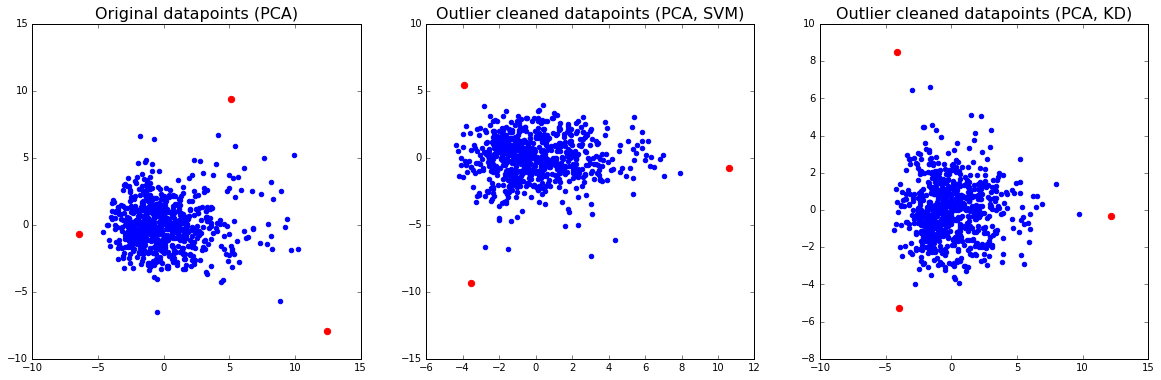


tc1


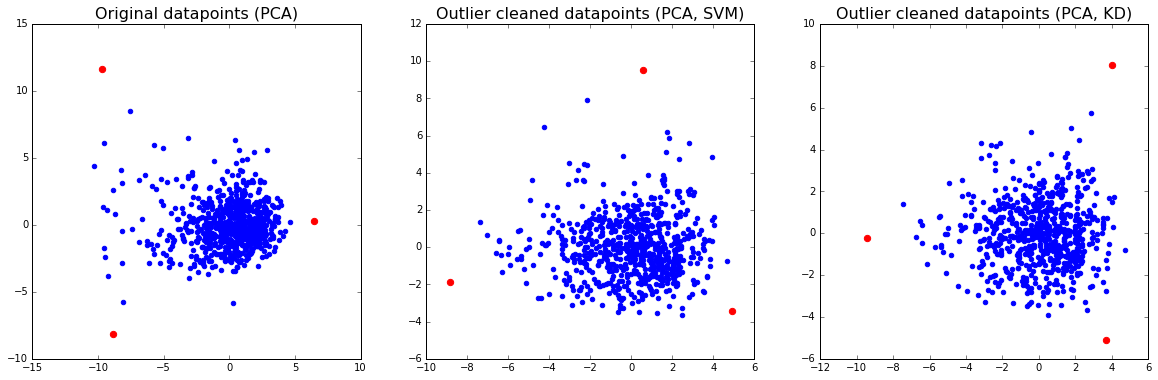


tc2


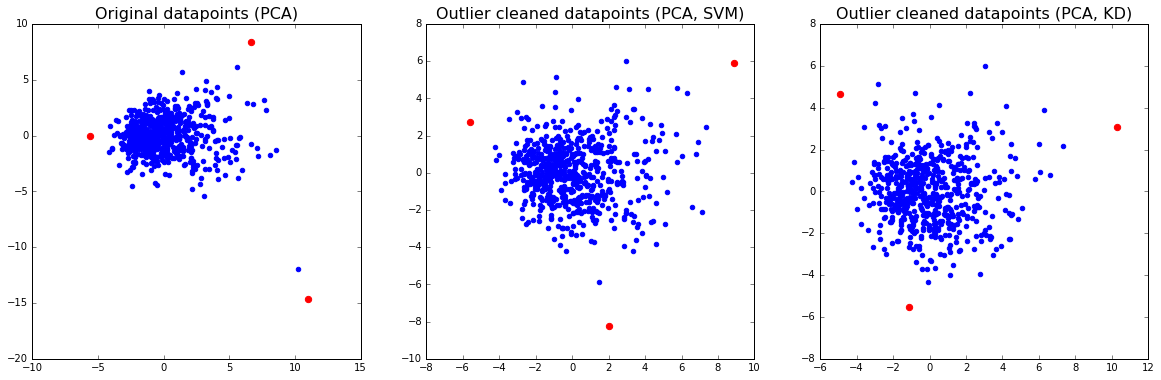


tc3


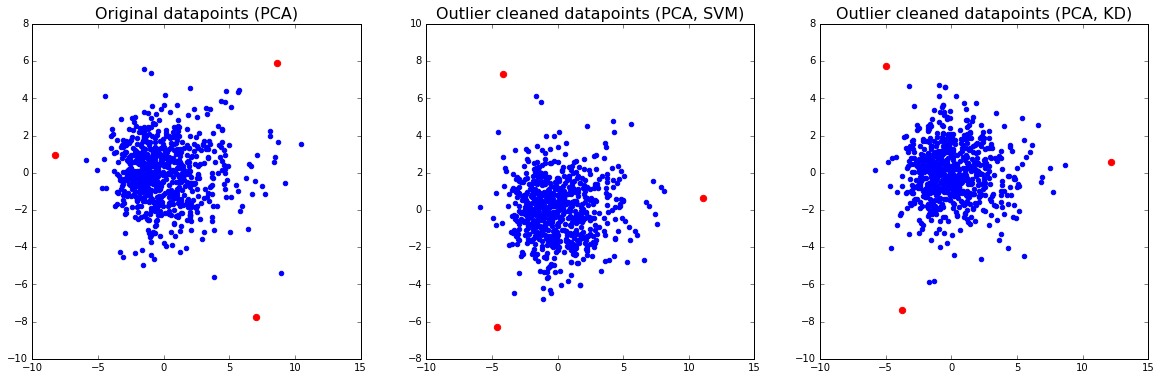

In [15]:
print "\ntc0"

plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc0
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc0_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc0_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc1"

plt.figure(1, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc1_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc2"

plt.figure(2, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc2_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

print "\ntc3"

plt.figure(3, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3_clean_svm
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)

pca = decomposition.PCA(n_components=2)
X0 = X_users_mean_tc3_clean_kd
pca.fit(X0)
X0 = pca.transform(X0)
XC, S, C, SSE, varexpl = PCHA(X0.T, 3, delta=0.4)

plt.scatter(X0[:, 0], X0[:, 1], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)

plt.show()

### All tc datasets projected onto PC1/PC2 for tc0

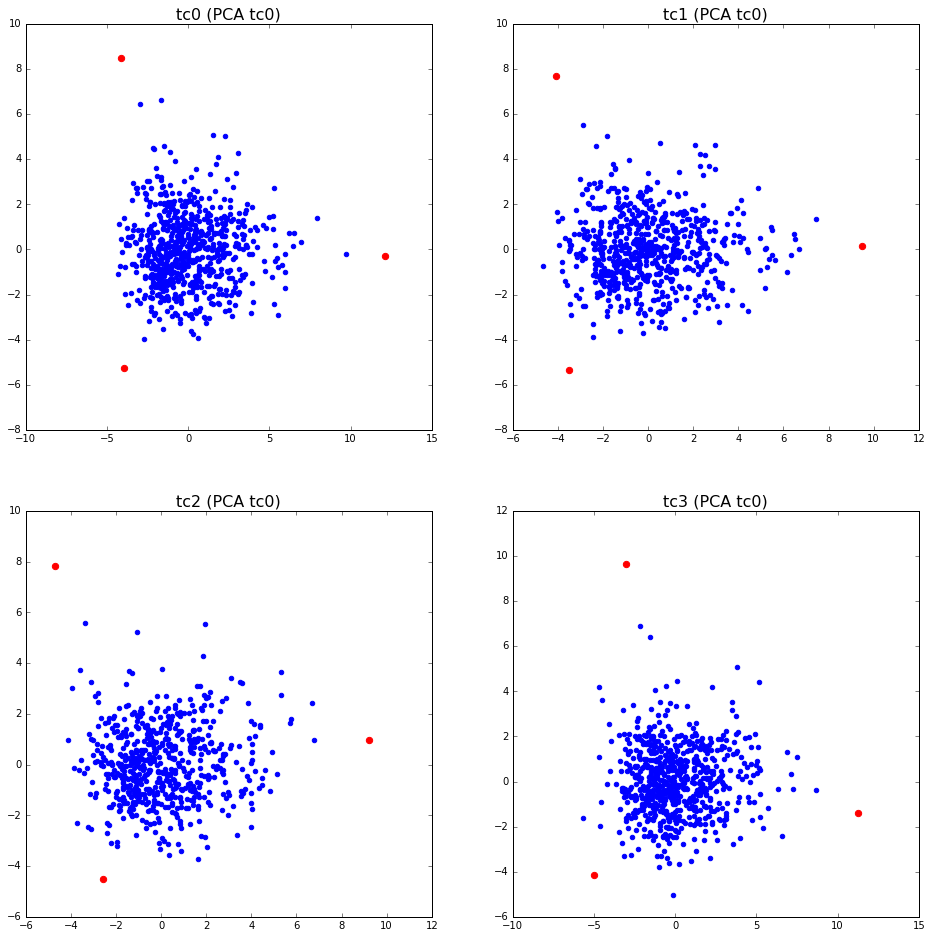

In [17]:
plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.title("tc0 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc0_clean_kd.T
pca = decomposition.PCA(n_components=2).fit(X0.T)  # <------ Is only fitted here!
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,2)
plt.title("tc1 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc1_clean_kd.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,3)
plt.title("tc2 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc2_clean_kd.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.subplot(2,2,4)
plt.title("tc3 (PCA tc0)", fontsize=16)

X0 = X_users_mean_tc3_clean_kd.T
X0 = pca.transform(X0.T).T
XC, S, C, SSE, varexpl = PCHA(X0, 3, delta=0.4)

plt.scatter(X0[0, :], X0[1, :], color="b")
plt.scatter(XC[0, :], XC[1, :], color="r", s=40)


plt.show()

# Pareto clustering

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from collections import defaultdict
from pareto_clustering.cluster.pareto_cluster import Pareto_cluster

In [22]:
X_users_mean_tc0_clean_svm = np.loadtxt("data/X_users_mean_tc0_clean_svm.csv", delimiter=",")
X_users_mean_tc0_clean_svm_valid_users = np.loadtxt("data/X_users_mean_tc0_clean_svm_valid_users.csv", delimiter=",")
feat_names = np.load("data/X_2014_week_feat_names.pickle")

In [23]:
X = X_users_mean_tc0_clean_svm
valid_users = X_users_mean_tc0_clean_svm_valid_users

### Cap too correlating features

del --x response_rate_call+text_mean
cor --> response_delay_call_mean -- 0.804875166662

del --x response_rate_call+text_std
cor --> response_delay_call_std -- 0.810382137035



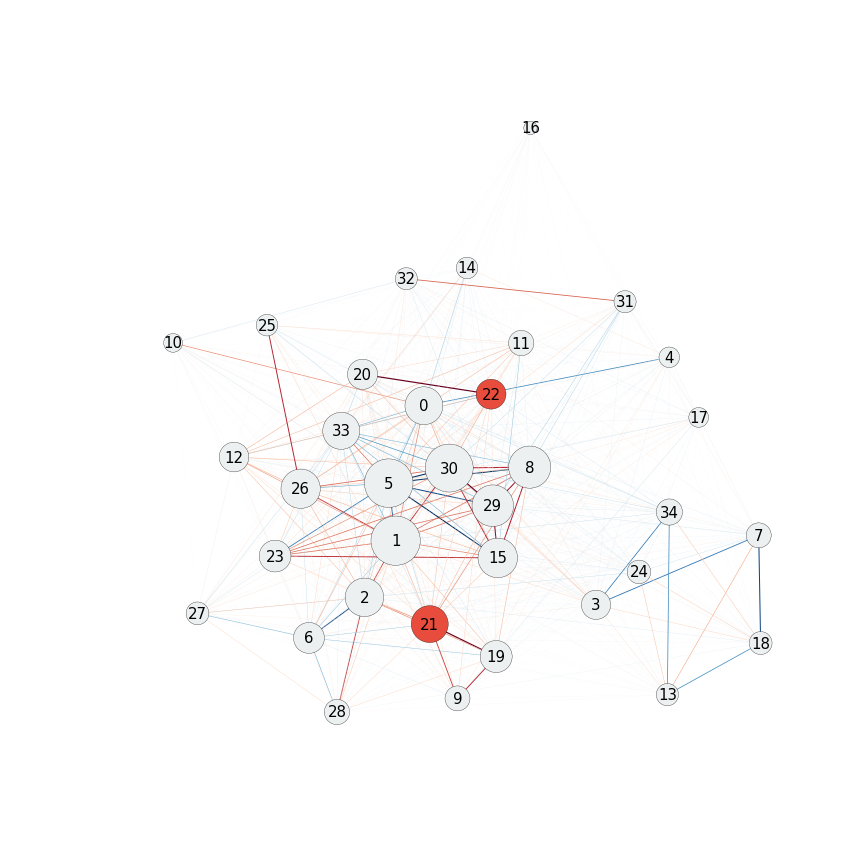

In [25]:
X = X_users_mean_tc0_clean_svm

feat_blacklist = []

sigma = np.corrcoef(X.T)
remove_cols = []

G = nx.Graph()

for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        
        G.add_edge(i, j, weight=abs(sigma[i, j]), color=sigma[i, j])
        
        if i >= j:# or j in remove_cols:
            continue
            
        if abs(sigma[i, j]) > 0.8:
            print "del --x", 
            print ''.join(feat_names[j].split("_allweek__allday__"))
            print "cor --> %s --"% ''.join(feat_names[i].split("_allweek__allday__")),
            print sigma[i, j]
            print
            
            remove_cols.append(j)

## ASSIGN
X = np.delete(X, remove_cols, axis=1)
feat_names = [fn for i, fn in enumerate(feat_names) if i not in remove_cols]


## SHOW GRAPH OF CORRELATION COEF MATRIX WITH CAP ENFORCED
plt.figure(figsize=(12,12))
plt.axis('off')
plt.tight_layout()

pos = nx.spring_layout(G, k=0.2)

edge_widths = np.log(np.array([abs(G[u][v]['weight']) for u,v in G.edges()])+1)*2
edge_colors = np.array([G[u][v]['color']  for u,v in G.edges()]).clip(min=-0.8, max=0.8)

degrees = [G.degree(weight='weight')[n] for n in G.nodes()]
node_sizes = (np.array(degrees)/np.mean(degrees)*30)**2
node_colors = ['#e74c3c' if n in remove_cols else '#ecf0f1' for n in G.nodes()]

label_names = dict((n, n) for n in G.nodes()) # ''.join(feat_names[n].split("_allweek__allday__"))

edges = nx.draw_networkx_edges(G, pos=pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.RdBu_r)
nodes = nx.draw_networkx_nodes(G, pos=pos, with_labels=False, node_size=node_sizes, node_color=node_colors)
labels = nx.draw_networkx_labels(G, pos=pos, font_size=15, labels=label_names)

plt.show()

In [28]:
#ds = defaultdict(list)
#for i in G.nodes():
#    ds['nodes'].append({"name": feat_names[i], "size": node_sizes[i], "label": i})
#    for j in G.nodes():
#        if i >= j:
#            continue
#        
#        ds['links'].append({'source': i, 'target': j, 'value': G[i][j]['weight'], 'color': np.sign(G[i][j]['color'])})


In [29]:
#filepath = '/Users/ulfaslak/Dropbox/school/sem12/MScProject/Academic/code/pipeline_code/visualisation/feature_correlation/data/'
#with open(filepath + 'ds.json', 'w') as outfile:
#    outfile.write(json.dumps(ds, indent=4))

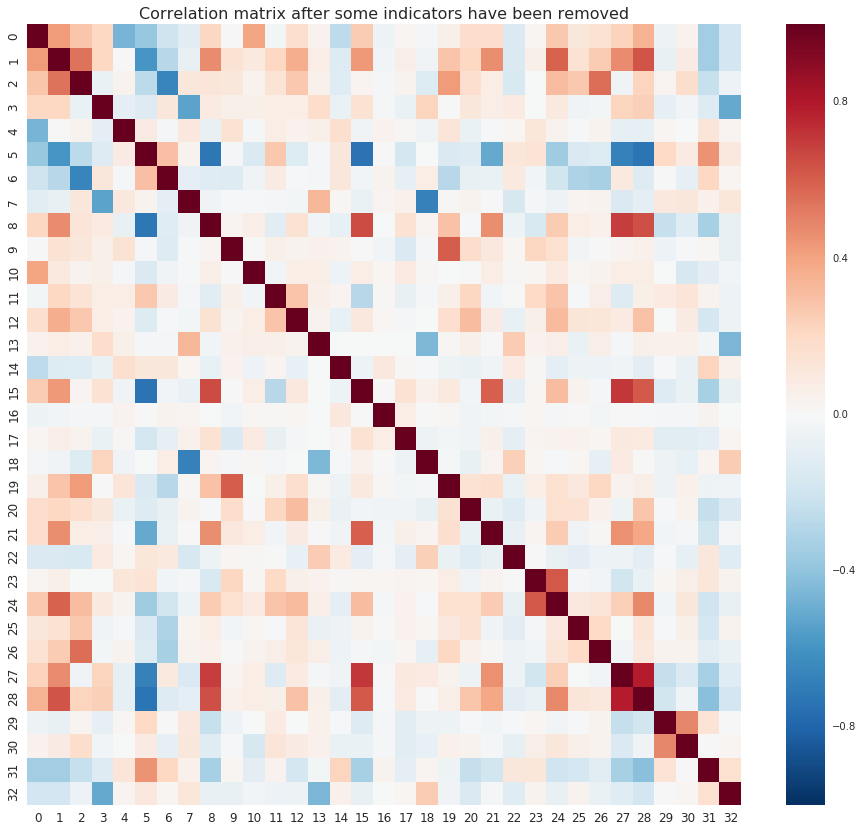

[(0, 'number_of_contacts_stop'),
 (1, 'number_of_contacts_text'),
 (2, 'number_of_contacts_call'),
 (3, 'number_of_contacts_physical'),
 (4, 'duration_stop'),
 (5, 'duration_text'),
 (6, 'duration_screen'),
 (7, 'duration_call'),
 (8, 'duration_physical'),
 (9, 'percent_nocturnal_screen'),
 (10, 'percent_nocturnal_stop'),
 (11, 'percent_initiated_conversations_call+text_mean'),
 (12, 'percent_initiated_conversations_call+text_std'),
 (13, 'percent_concluded_conversations_call+text_mean'),
 (14, 'percent_concluded_conversations_call+text_std'),
 (15, 'overlap_conversations_per_contacts_text'),
 (16, 'overlap_conversations_per_contacts_physical'),
 (17, 'response_delay_text_mean'),
 (18, 'response_delay_text_std'),
 (19, 'response_delay_call_mean'),
 (20, 'response_delay_call_std'),
 (21, 'entropy_per_contacts_stop'),
 (22, 'entropy_per_contacts_text'),
 (23, 'entropy_per_contacts_call'),
 (24, 'entropy_per_contacts_physical'),
 (25, 'balance_of_interactions_text'),
 (26, 'balance_of_int

In [30]:
plt.figure(figsize=(16,14))
plt.title("Correlation matrix after some indicators have been removed", fontsize=16)
sns.heatmap(pd.DataFrame(np.corrcoef(X.T)))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
[(i, '_'.join(n.split("__allweek__allday__"))) for i, n in enumerate(feat_names)]

In [31]:
pareto_cluster = Pareto_cluster(num_iter=10, sample_size=1.0, remove_outliers=True, visualize=True)
pareto_cluster.fit(X)

ImportError: No module named p2t

In [44]:
clusters_infomap = pareto_cluster.Infomap()
clusters_dbscan = pareto_cluster.DBSCAN()

3 clusters and 0 outliers
3 clusters and 1 outliers
3 clusters and 2 outliers
3 clusters and 3 outliers
3 clusters and 7 outliers
3 clusters and 8 outliers
3 clusters and 9 outliers
	... found 1 valid solutions, using eps=1.854227, min_samples=11 (minimal params)


In [49]:
clusters_dbscan

array([-1,  0, -1,  1, -1,  0, -1, -1,  1,  0,  1,  1,  1, -1,  1,  0, -1,
        2,  0,  2,  1,  0,  0,  0,  0,  0, -1,  2,  1,  2,  0,  1,  1,  1,
        1,  0,  2,  1, -1])

In [46]:
from itertools import groupby
import json

#clusters_dbscan = pareto_cluster.DBSCAN()

groups = []
for _, g in groupby(sorted(zip(clusters_dbscan, feat_names), key=lambda x: x[0]), key=lambda x: x[0]):
    groups.append([e[1] for e in g])

for g in groups:
    print json.dumps(g, indent=2)

[
  "number_of_contacts__allweek__allday__stop", 
  "number_of_contacts__allweek__allday__call", 
  "duration__allweek__allday__stop", 
  "duration__allweek__allday__screen", 
  "duration__allweek__allday__call", 
  "percent_concluded_conversations__allweek__allday__call+text_mean", 
  "overlap_conversations_per_contacts__allweek__allday__physical", 
  "entropy_per_contacts__allweek__allday__physical", 
  "overlap_screen_physical__allweek__allday__screen+physical"
]
[
  "number_of_contacts__allweek__allday__text", 
  "duration__allweek__allday__text", 
  "percent_nocturnal__allweek__allday__screen", 
  "overlap_conversations_per_contacts__allweek__allday__text", 
  "response_delay__allweek__allday__text_std", 
  "response_rate__allweek__allday__call+text_mean", 
  "response_rate__allweek__allday__call+text_std", 
  "entropy_per_contacts__allweek__allday__stop", 
  "entropy_per_contacts__allweek__allday__text", 
  "entropy_per_contacts__allweek__allday__call", 
  "interactions_per_conta

In [127]:
print feat_names[2]
print feat_names[30]

number_of_contacts__allweek__allday__call
number_of_interactions__allweek__allday__call


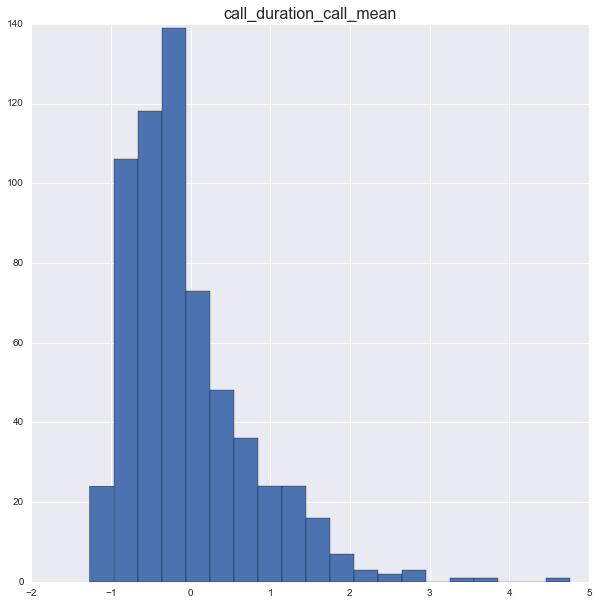

In [110]:
j = 4
plt.figure(figsize=(10,10))
plt.title(''.join(feat_names[j].split("_allweek__allday__")), fontsize=16)
plt.hist(X[:, j], bins=20)
plt.show()

In [512]:
def time_correlated_entropy(walk):
    counter = Counter(zip(walk[:-1], walk[1:]))
    P = np.array(counter.values(), float) / np.sum(counter.values())
    return - sum(P * np.log2(P))

def shannon_entropy(data):
    data = np.array(Counter(walk).values()) * 1.0/ len(data)
    data = data *1.0 / sum(data)
    return - sum(
        data * np.log2(data)
    )

In [ ]:
x_call, y_call, z_call = [], [], []
x_text, y_text, z_text = [], [], []
x_physical, y_physical, z_physical = [], [], []
x_stop, y_stop, z_stop = [], [], []
    
    walk = [r.correspondent_id for r in user.physical_records]
    n = len(set(walk))
    x_physical.append(n)
    y_physical.append(shannon_entropy(walk))
    z_physical.append(time_correlated_entropy(walk))
    
    walk = [r.correspondent_id for r in user.call_records]
    x_call.append(n)
    y_call.append(shannon_entropy(walk))
    z_call.append(time_correlated_entropy(walk))

    walk = [r.correspondent_id for r in user.text_records]
    x_text.append(n)
    y_text.append(shannon_entropy(walk))
    z_text.append(time_correlated_entropy(walk))
    
    walk = [r.position for r in user.stop_records]
    x_stop.append(n)
    y_stop.append(shannon_entropy(walk))
    z_stop.append(time_correlated_entropy(walk))

In [39]:
def _processed_users(tc):
    interaction_types = ["call", "text", "physical", "screen", "stop"]
    counter = Counter()
    for t in interaction_types:
        users = [int(f.split(".")[0]) for f in os.listdir("build_dataset/data_cache/records/%s/%s" % (t, tc))]
        counter.update(users)
    return [k for k,v in counter.items() if v == 5]

def _threshold_test(user):
    def __recs_per_day(records):
        counter = len(records) * 1.0
        span = (max(records, key=lambda r: r.datetime).datetime - \
                min(records, key=lambda r: r.datetime).datetime).days
        return counter/span
    
    thresholds = [
        (user.text_records, 2),
        (user.call_records, 1),
        (user.physical_records, 1),
        (user.screen_records, 20),
        (user.stop_records, 1)
    ]
    
    for records, thr in thresholds:
        if __recs_per_day(records) < thr:
            return False
    return True

users_records = {}
users_below_thresh = []
tc = "tc0"
for u in _processed_users(tc):
    user = bc_d.read_csv(
        "%d" % u, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        screen_path="build_dataset/data_cache/records/screen/%s/" % tc, 
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
        network=False,
        describe=False
    )
    try:
        if not _threshold_test(user):
            users_below_thresh.append(u)
            
        users_records[u] = {
            "call": len(user.call_records) * 1.0 / (max(user.call_records, key=lambda r: r.datetime).datetime - min(user.call_records, key=lambda r: r.datetime).datetime).days ,
            "text": len(user.text_records) * 1.0 / (max(user.text_records, key=lambda r: r.datetime).datetime - min(user.text_records, key=lambda r: r.datetime).datetime).days ,
            "physical": len(user.physical_records) * 1.0 / (max(user.physical_records, key=lambda r: r.datetime).datetime - min(user.physical_records, key=lambda r: r.datetime).datetime).days ,
            "screen": len(user.screen_records) * 1.0 / (max(user.screen_records, key=lambda r: r.datetime).datetime - min(user.screen_records, key=lambda r: r.datetime).datetime).days ,
            "stop": len(user.stop_records) * 1.0 / (max(user.stop_records, key=lambda r: r.datetime).datetime - min(user.stop_records, key=lambda r: r.datetime).datetime).days 
        }
    except ZeroDivisionError:
        print u
        users_below_thresh.append(u)

25
134
763
809
811


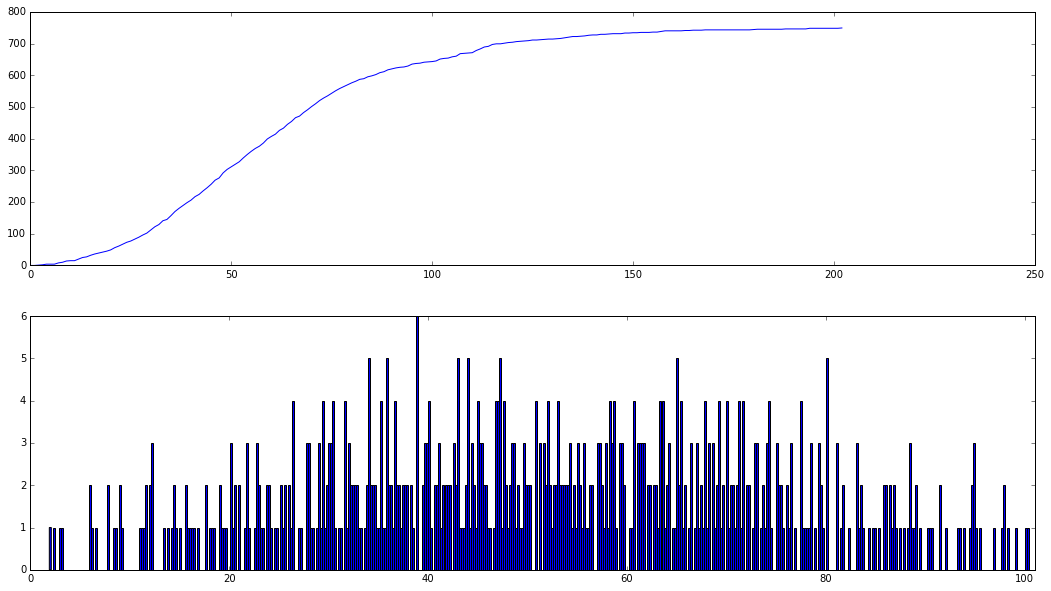

In [32]:
dtype="screen"
maxval = int(max([v[dtype] for v in users_records.values()])) + 1

y = []
for i in range(maxval):
    y.append(len([v[dtype] for v in users_records.values() if v[dtype] < i]))

plt.figure(figsize=(18,10))
plt.subplot(2,1,1)
plt.plot(range(maxval), y)
plt.subplot(2,1,2)
plt.hist([v[dtype] for _, v in users_records.items()], bins=1000)
plt.xlim([0, maxval/2])
plt.show()

In [40]:
len(users_below_thresh)

143

In [322]:
a, b = [], []

for u in range(500):
    tc = "tc0"
    user = bc_d.read_csv(
                "%d" % u, 
                #call_path="build_dataset/data_cache/records/call/%s/" % tc,
                #text_path="build_dataset/data_cache/records/text/%s/" % tc,
                physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
                #screen_path="build_dataset/data_cache/records/screen/%s/" % tc, 
                stop_path="build_dataset/data_cache/records/stop/%s/" % tc, 
                network=False,
                describe=False
            )
    records = sorted(user.physical_records + user.stop_records, key=lambda r: r.datetime)
    try:
        x, y = percent_outside_campus_from_campus(records)
    except ZeroDivisionError:
        print u
        continue
    a.append(x)
    b.append(y)

41
60
176
212
260
316
417
454
484
490


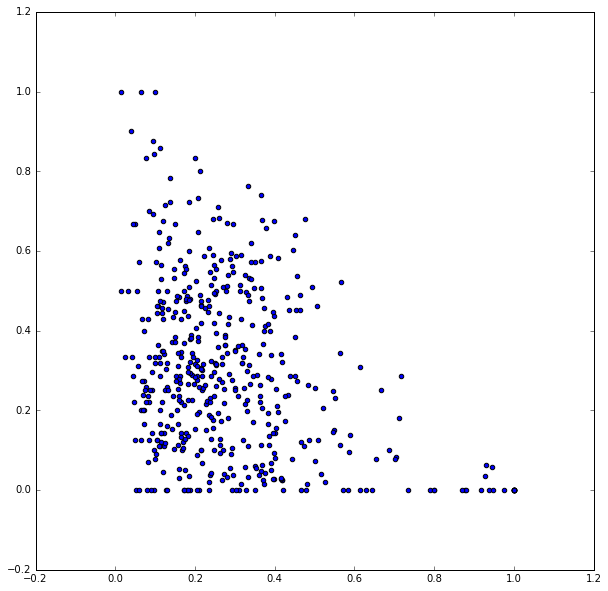

In [323]:
plt.figure(figsize=(10,10))
plt.scatter(a, b)
plt.show()

In [371]:
(dt.fromtimestamp(1111111111) - dt.fromtimestamp(1114111111)).days

-35

In [135]:
import datetime

def entropy(data):
    """
    Compute the Shannon entropy, a measure of uncertainty.
    """
    if len(data) == 0:
        return None
    _op = lambda f: f * np.log2(f)
    return - sum(_op(float(i) / sum(data)) for i in data)

def entropy_per_contacts(records, normalize=True):
    """Entropy of the user's contacts. Time uncorrelated.

    Parameters
    ----------
    normalize: boolean, default is False
        Returns a normalized entropy between 0 and 1.
    """
    try:
        counter = Counter(r.correspondent_id for r in records)
    except AttributeError:
        counter = Counter(r.position for r in records)

    raw_entropy = entropy(counter.values())
    n = len(counter)
    if normalize and n > 1:
        return raw_entropy / n
    else:
        return raw_entropy


x_call, y_call = [], []
x_text, y_text = [], []
x_physical, y_physical = [], []
x_screen, y_screen = [], []
x_stop, y_stop = [], []

tc = "tc0"
for u in _processed_users(tc):
    user = bc_d.read_csv(
        "%d" % u, 
        call_path="build_dataset/data_cache/records/call/%s/" % tc,
        text_path="build_dataset/data_cache/records/text/%s/" % tc,
        physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
        #screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
        stop_path="build_dataset/data_cache/records/stop/%s/" % tc,
        network=False,
        describe=False
    )
    
    x_call.append(entropy_per_contacts(user.call_records))
    y_call.append(len(user.call_records))

    x_text.append(entropy_per_contacts(user.text_records))
    y_text.append(len(user.text_records))

    x_physical.append(entropy_per_contacts(user.physical_records))
    y_physical.append(len(user.physical_records))

    x_stop.append(entropy_per_contacts(user.stop_records))
    y_stop.append(len(user.stop_records))

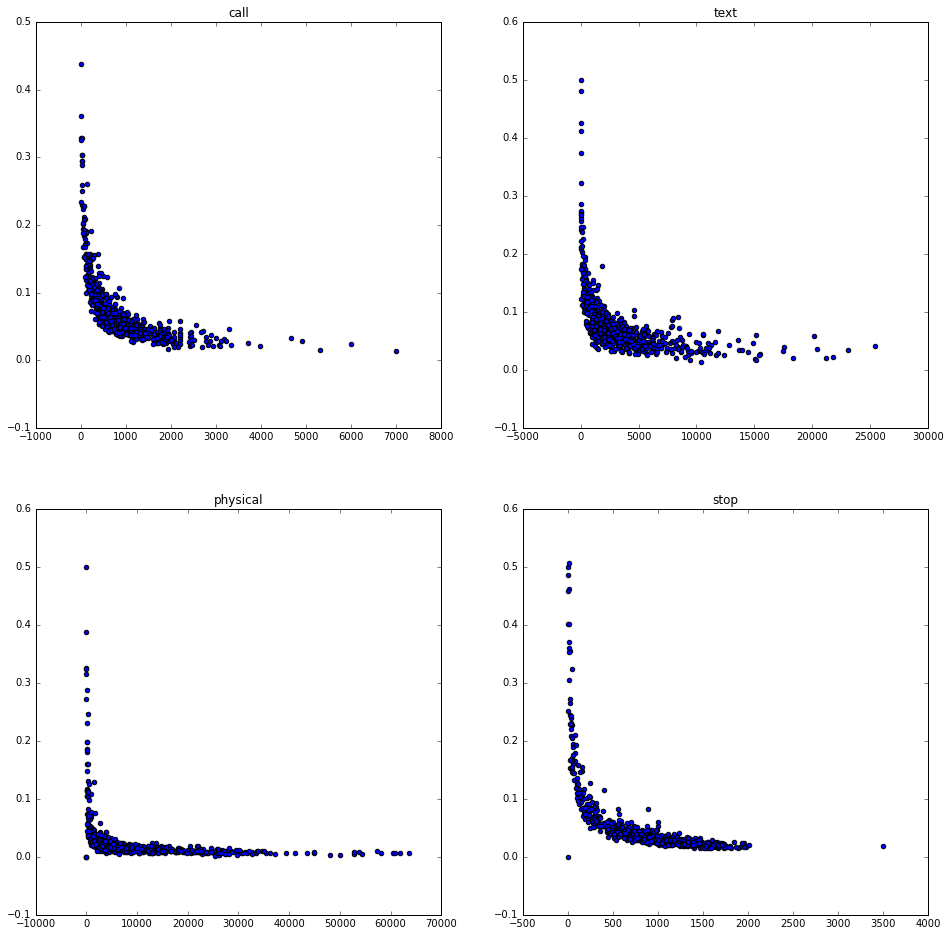

In [136]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("call")
plt.scatter(y_call, x_call)
plt.subplot(2, 2, 2)
plt.title("text")
plt.scatter(y_text, x_text)
plt.subplot(2, 2, 3)
plt.title("physical")
plt.scatter(y_physical, x_physical)
plt.subplot(2, 2, 4)
plt.title("stop")
plt.scatter(y_stop, x_stop)
plt.show()

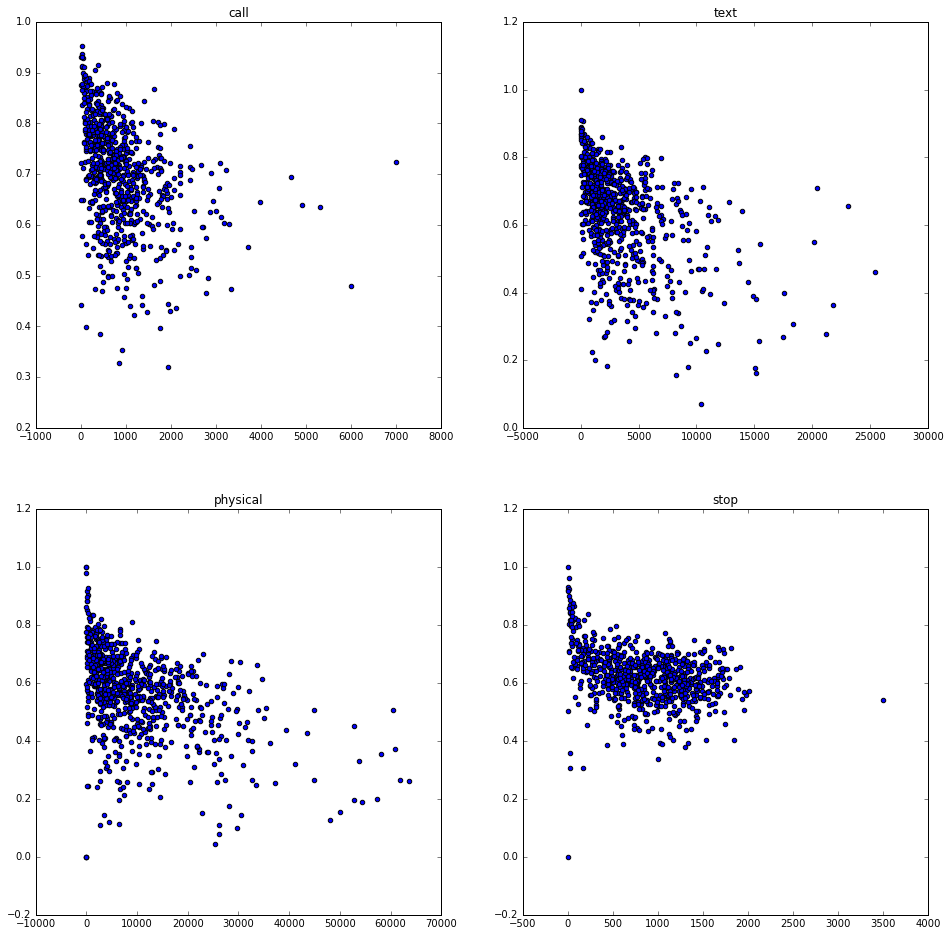

In [134]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("call")
plt.scatter(y_call, x_call)
plt.subplot(2, 2, 2)
plt.title("text")
plt.scatter(y_text, x_text)
plt.subplot(2, 2, 3)
plt.title("physical")
plt.scatter(y_physical, x_physical)
plt.subplot(2, 2, 4)
plt.title("stop")
plt.scatter(y_stop, x_stop)
plt.show()

In [10]:
tc = "tc0"
user = bc_d.read_csv(
    "%d" % 0, 
    call_path="build_dataset/data_cache/records/call/%s/" % tc,
    text_path="build_dataset/data_cache/records/text/%s/" % tc,
    physical_path="build_dataset/data_cache/records/physical/%s/" % tc,
    screen_path="build_dataset/data_cache/records/screen/%s/" % tc,
    stop_path="build_dataset/data_cache/records/stop/%s/" % tc,
    network=False,
    describe=True
)

[x] 1164 call_records from 2014-01-01 01:32:01 to 2014-12-30 19:23:08
[x] 3598 text_records from 2014-01-01 07:29:06 to 2014-12-30 19:08:13
[ ] No physical_records stored
[x] 41583 screen_records from 2014-01-01 01:16:52 to 2014-12-30 23:52:34
[x] 1578 stop_records from 2014-01-02 18:45:00 to 2014-12-30 18:45:00
[ ] No contacts
[ ] No attribute stored
[x] Has texts
[x] Has calls
[ ] No network


In [8]:
indicators = bc_d.utils.all(
    user,
    groupby=None,
    dist=True,
    network=False,
    spatial=False
)

TypeError: all() got an unexpected keyword argument 'describe'

In [16]:
bc_d.individual.number_of_contacts(user, interaction='callandtextandphysical', groupby=None)

{'allweek': {'allday': {'call+text+physical': 362}}}

In [13]:
indicators

OrderedDict([('name', '0'),
             ('reporting',
              OrderedDict([('attributes_path', None),
                           ('version', '0.4.0'),
                           ('groupby', None),
                           ('split_week', False),
                           ('split_day', False),
                           ('start_time_call', '2014-01-01 01:32:01'),
                           ('end_time_call', '2014-12-30 19:23:08'),
                           ('night_start', '22:00:00'),
                           ('night_end', '07:00:00'),
                           ('weekend', [6, 7]),
                           ('bins', 1),
                           ('has_call', True),
                           ('has_text', True),
                           ('has_physical', True),
                           ('has_screen', True),
                           ('has_stop', True),
                           ('has_home', False),
                           ('has_network', False),
                   

In [6]:
len(gen)

TypeError: object of type 'function' has no len()

In [8]:
dt.fromtimestamp(1481847478).isocalendar()

(2016, 50, 5)